In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import salem
from utils import constants as cnst
from wavelet import util, wav
from scipy.ndimage.measurements import label
from scipy import ndimage
from utils import u_arrays as ua, u_grid
from wavelet import util
import numpy.ma as ma
import pickle as pkl
from eod import mfg
from utils import u_grid, u_interpolate as u_int
from kpywavelet import wavelet as wvt
from utils import u_plot as uplot

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

/tmp/ipykernel_15987/783167702.py:15: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
all_data = xr.open_dataset('/media/ck/Elements/global/annual_trend_data/lst_monthly_trends.nc')  #mean_lst_trend_1991_2019_dsett10.nc')

In [4]:
all_data

<xarray.Dataset>
Dimensions:        (lat: 3600, lon: 7200, time: 12)
Dimensions without coordinates: lat, lon, time
Data variables:
    Longitude      (lon) float32 ...
    Latitude       (lat) float32 ...
    Month          (time) uint8 ...
    LST_trend      (time, lon, lat) float32 ...
    Warming_month  (time, lon, lat) uint8 ...
    Cooling_month  (time, lon, lat) uint8 ...

In [5]:
all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [6]:
lon2d, lat2d = np.meshgrid(all_data.Longitude, all_data.Latitude)

In [7]:
box = [-18,20,3,12]

In [8]:
months = all_data.where((all_data.Longitude>box[0])&(all_data.Longitude<box[1])&(all_data.Latitude>box[2])&(all_data.Latitude<box[3]), drop=True)

In [9]:
months = months['LST_trend']

In [10]:
data = months.isel(time=1)

In [11]:
#data = data.sel(lat=slice(4.5,8))

In [12]:
#data = data.sel(lat=slice(4,11), lon=slice(-15,10))

(array([3.0000e+00, 2.0000e+00, 2.0000e+00, 9.0000e+00, 1.0700e+02,
        6.4710e+03, 6.9627e+04, 2.0401e+04, 6.0900e+02, 1.3000e+01]),
 array([-1.196929  , -1.0170413 , -0.8371536 , -0.65726596, -0.47737828,
        -0.2974906 , -0.11760292,  0.06228476,  0.24217243,  0.4220601 ,
         0.6019478 ], dtype=float32),
 <BarContainer object of 10 artists>)

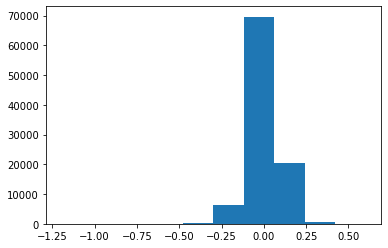

In [13]:
plt.hist(data.values.flat[np.isfinite(data.values.flat)])

In [14]:
mask = np.isfinite(data.values)

In [15]:
mask.shape

(759, 179)

In [16]:
#data.values[data.values<=-998]=0.01
data.values[np.isnan(data.values)]=-0.01

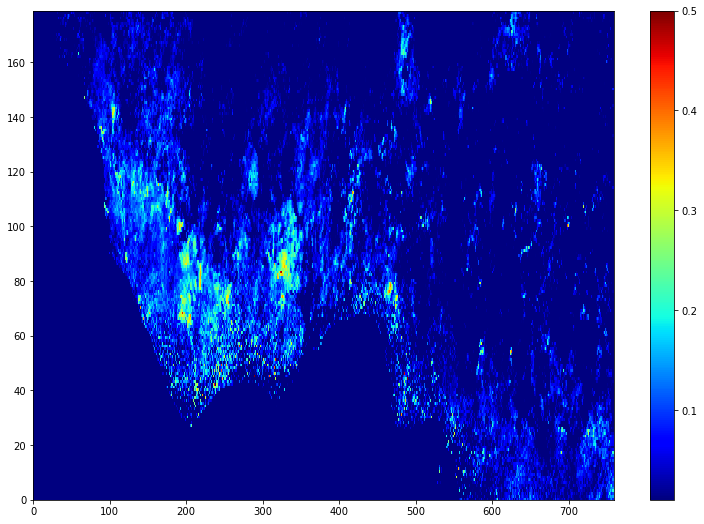

In [72]:
plt.figure(figsize=(13,9))
plt.pcolormesh(data.T,cmap='jet', vmin=0.01, vmax=0.5)
plt.colorbar()

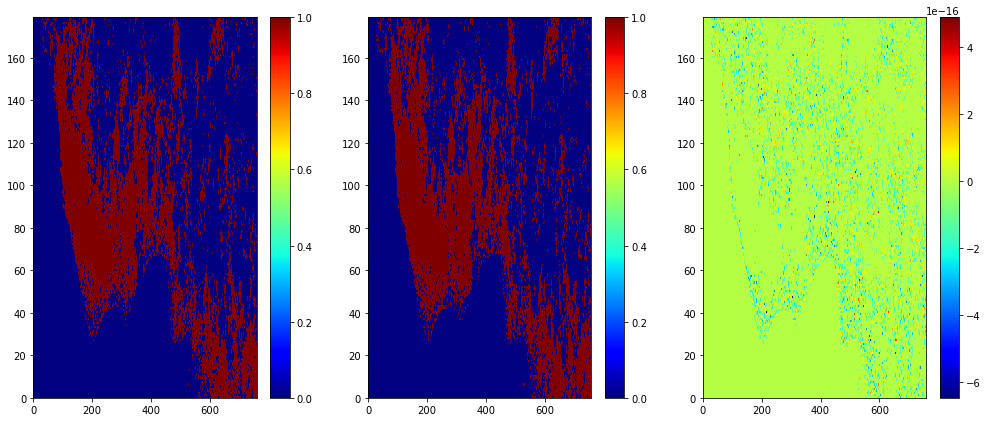

In [73]:
from utils import u_arrays as ua

testin = np.zeros_like(data.values.T)
testin[data.values.T>0.01] = 1

#testin = testin.astype(int)

test, test2 = ua.rotate(testin, 90, ref_angle=90)


f = plt.figure(figsize=(17,7))
ax = f.add_subplot(131)
plt.pcolormesh(test,cmap='jet')
plt.colorbar()
ax = f.add_subplot(132)
plt.pcolormesh(test2,cmap='jet')
plt.colorbar()
ax = f.add_subplot(133)
plt.pcolormesh(test - test2,cmap='jet')
plt.colorbar()

In [74]:
test

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

(array([94607.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 41254.]),
 array([-4.900096e-16,  1.000000e-01,  2.000000e-01,  3.000000e-01,
         4.000000e-01,  5.000000e-01,  6.000000e-01,  7.000000e-01,
         8.000000e-01,  9.000000e-01,  1.000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

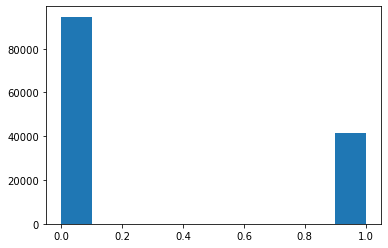

In [75]:
plt.hist(test2.flatten())

(array([94607.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 41254.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

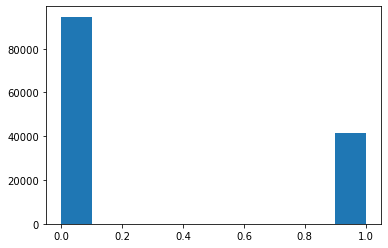

In [76]:
plt.hist(test.flatten())

In [60]:
np.unique(testin)

array([0., 1.], dtype=float32)

In [84]:
dic = util.waveletT1D(data.values, dataset='LSTATREND5K_GLOBAL', mask=mask, sign='negative')
scale_ind =1

(0.0, 0.32)

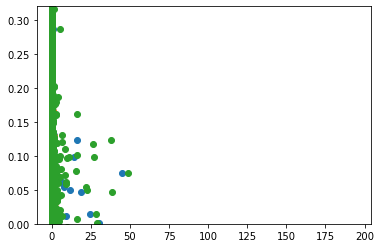

In [85]:
plt.scatter(dic['powerx'][5,:,:], data)
plt.scatter(dic['powerx'][2,:,:], data)
plt.scatter(dic['powerx'][7,:,:], data)
plt.ylim(0,0.32)

In [86]:
np.percentile(dic['powery'],99.7)

6.856625076808861

In [87]:
def filters(power, sig):
    out = power.copy()
    cnt = 0
    for p, s in zip(power,sig):
        part = out[cnt,:,:]

        mini = np.min(p[s.astype(np.bool)])
        part[part<mini] = 0
        out[cnt,:,:] = part
        cnt += 1
        return out

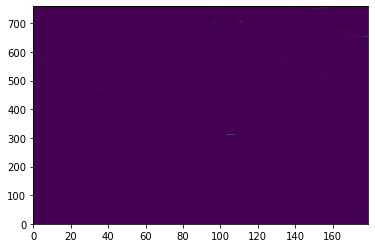

In [88]:
plt.pcolormesh(dic['powery'][scale_ind,:,:])

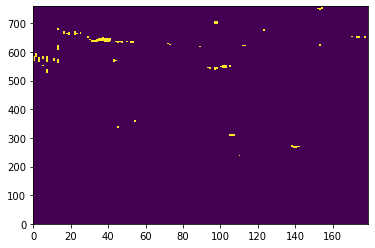

In [89]:
plt.pcolormesh(dic['sigy'][7,:,:])

In [90]:
np.min((dic['powery'][scale_ind,:,:])[(dic['sigy'][scale_ind,:,:]).astype(np.bool)])

0.03623103029037468

In [91]:
np.min((dic['powery'][scale_ind,:,:]))

1.1321358149412854e-25

In [92]:
dic['scales']

array([ 15.        ,  19.79261866,  26.1165169 ,  34.46095065,
        45.471497  ,  60.        ,  79.17047465, 104.4660676 ,
       137.8438026 , 181.88598798, 240.        , 316.68189859,
       417.86427038, 551.3752104 , 727.54395192])

In [93]:
sigy = filters(dic['powery'], dic['sigy'])

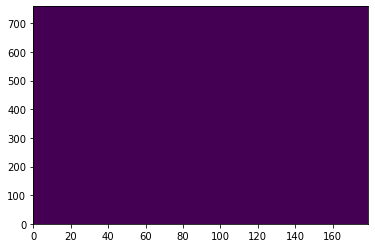

In [94]:
plt.pcolormesh(dic['powery'][scale_ind,:,:]-sigy[scale_ind,:,:])

65
[-45 -44 -44 ...  84  84  85]


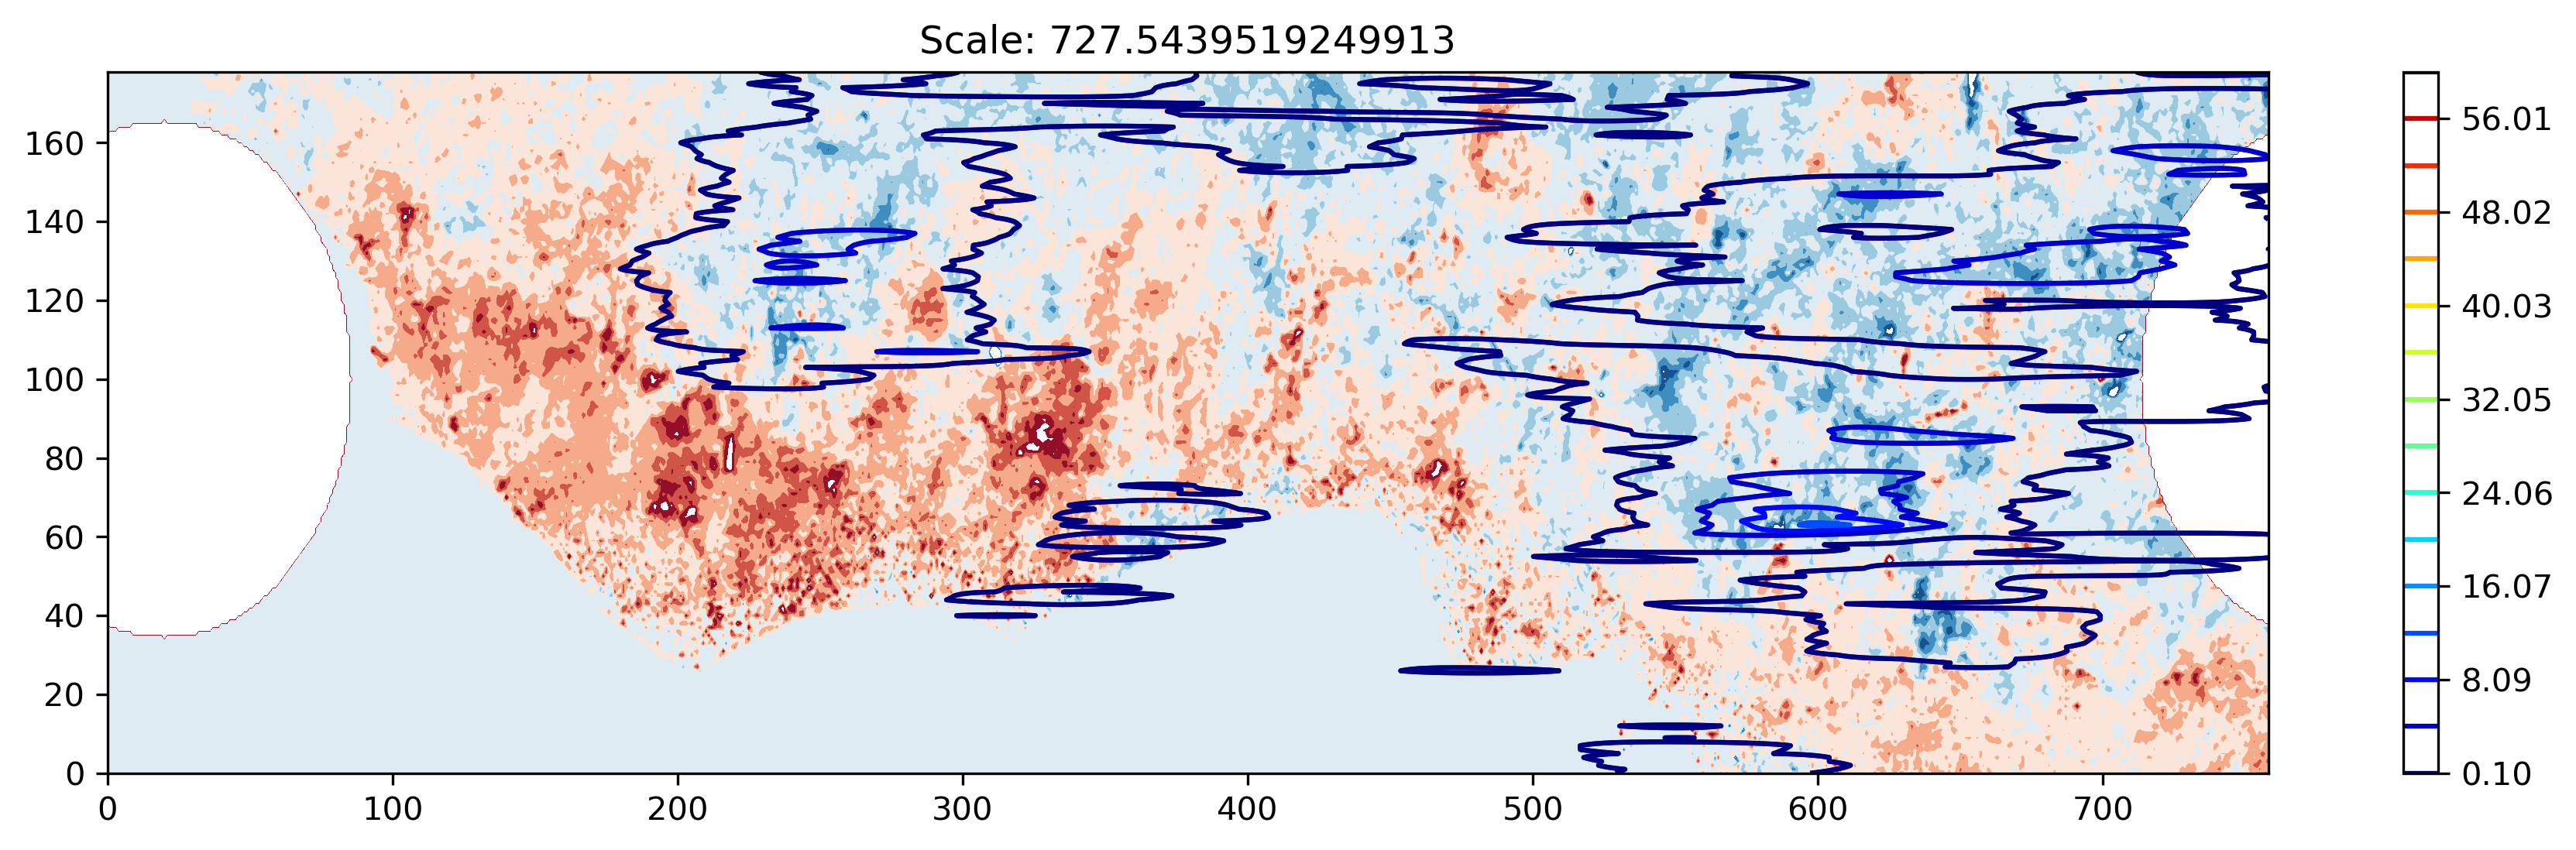

In [97]:
scale_ind = -1
iscale = (np.floor(dic['scales'][scale_ind] / 2. / 5.55)).astype(int)
print(iscale)
ycircf, xcircf = ua.draw_cut_circle(100, 20, iscale, data.values)
print(ycircf)
data.values[ycircf,xcircf] = 50
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111)
mapp = ax.contourf(data.values.T,levels=np.linspace(-0.3,0.3,9), cmap='RdBu_r')
mapp = ax.contour(dic['powery'][scale_ind,:,:].T, levels=np.linspace(0.1,60,16))
mapp = ax.contour(dic['powery'][scale_ind,:,:].T, levels=np.linspace(0.1,60,16), cmap='jet')
#mapp = ax.contour(dic['powery'][4,:,:], levels=np.linspace(7,60,6), cmap='Greens')
plt.title('Scale: '+str(dic['scales'][scale_ind]))


plt.colorbar(mapp)

21
[-1  0  0 ... 40 40 41]


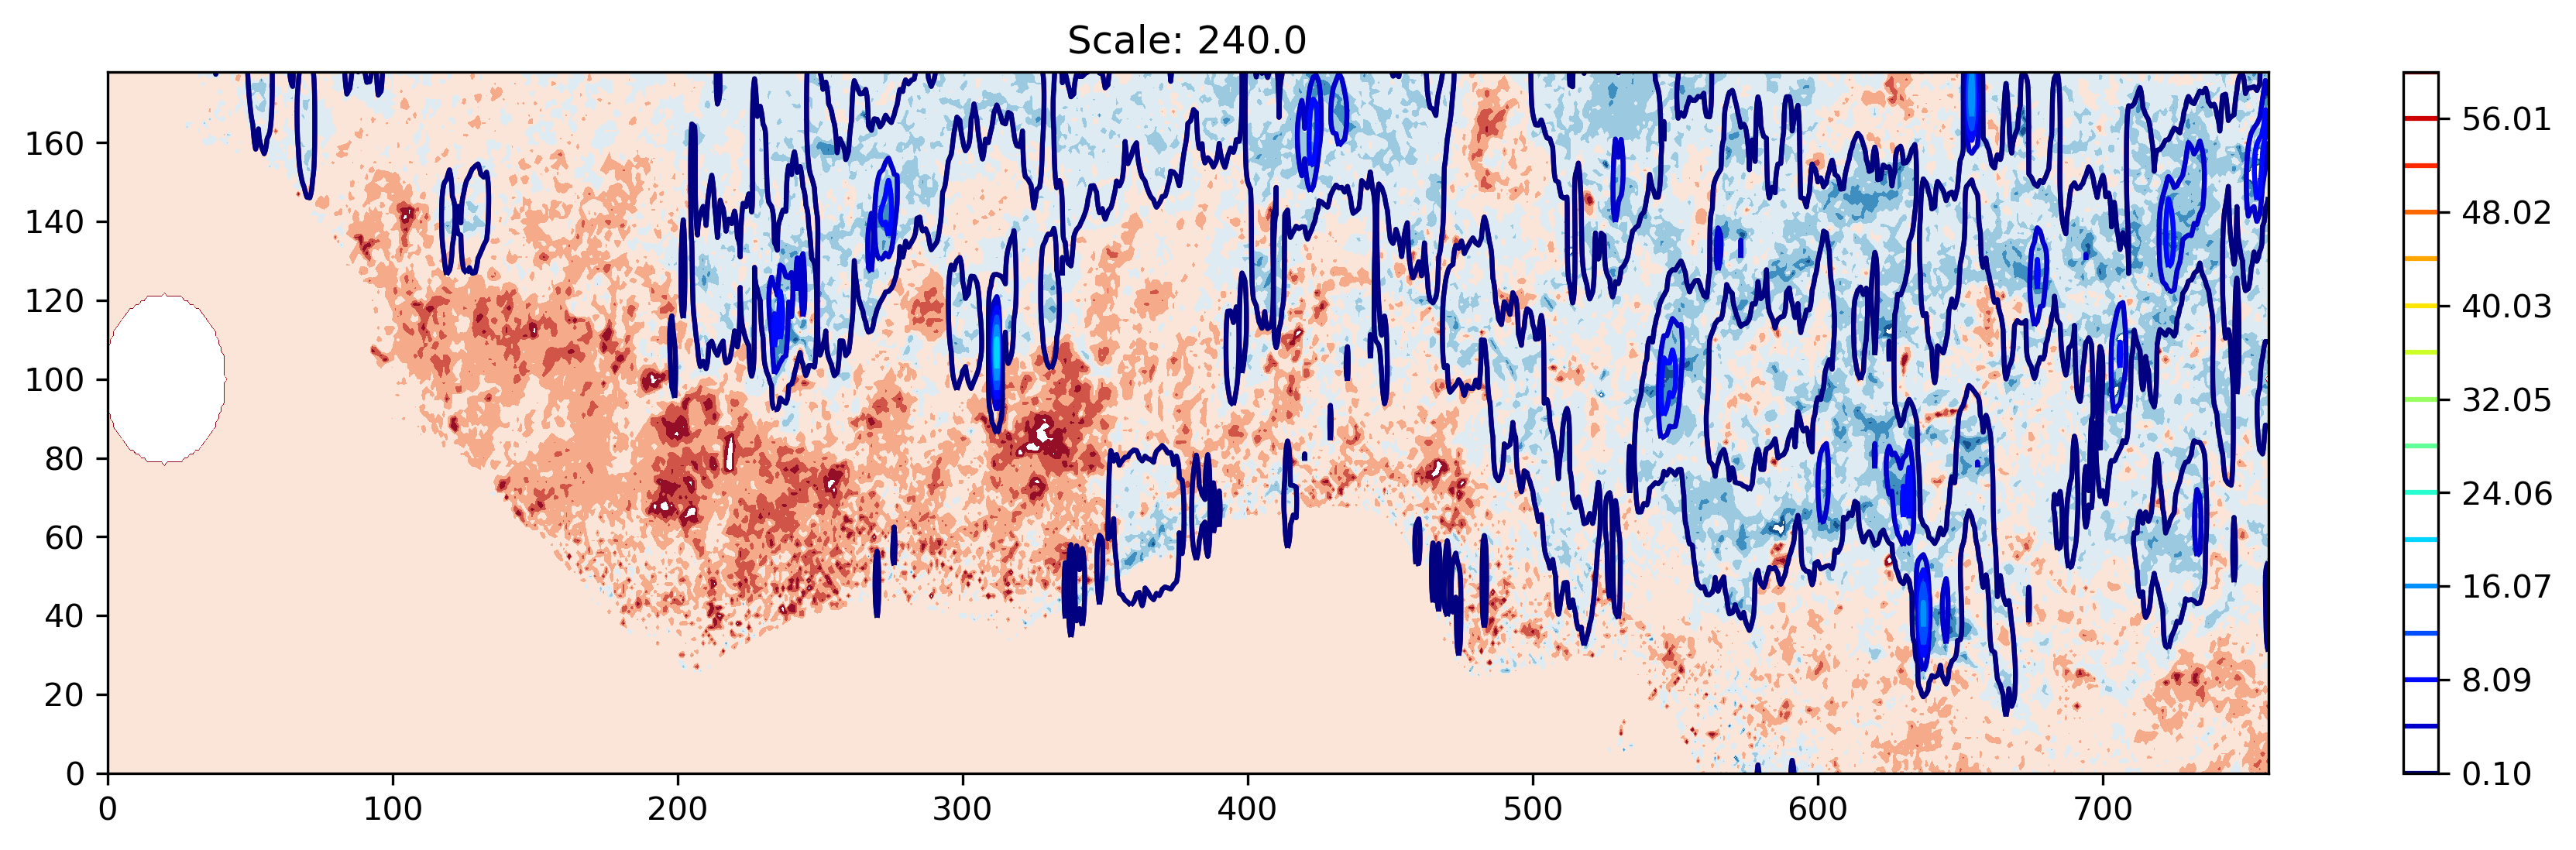

In [335]:
scale_ind = -5
iscale = (np.floor(dic['scales'][scale_ind] / 2. / 5.55)).astype(int)
print(iscale)
ycircf, xcircf = ua.draw_cut_circle(100, 20, iscale, data.values)
print(ycircf)
data.values[ycircf,xcircf] = 50
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111)
mapp = ax.contourf(data.values.T,levels=np.linspace(-0.3,0.3,9), cmap='RdBu_r')
mapp = ax.contour(dic['powerx'][scale_ind,:,:].T, levels=np.linspace(0.1,60,16))
mapp = ax.contour(dic['powerx'][scale_ind,:,:].T, levels=np.linspace(0.1,60,16), cmap='jet')
#mapp = ax.contour(dic['powery'][4,:,:], levels=np.linspace(7,60,6), cmap='Greens')
plt.title('Scale: '+str(dic['scales'][scale_ind]))


plt.colorbar(mapp)

In [307]:
maxperpix = dic['powery'].argmax(axis=0)

dom_scale = np.zeros_like(data)
power_scale = np.zeros_like(data)
scales = dic['scales']
for i in range(maxperpix.shape[0]):
    for j in range(maxperpix.shape[1]):
        max = maxperpix[i,j]

        power = dic['powery'][:,i,j]
        scal = scales[max]
        power_max = power[max]
        
        if power_max < 5:
            power_max = -999
            scal = -999
        power_scale[i,j] = power_max
        dom_scale[i,j] = scal



In [308]:
dic['scales']

array([ 15.        ,  19.79261866,  26.1165169 ,  34.46095065,
        45.471497  ,  60.        ,  79.17047465, 104.4660676 ,
       137.8438026 , 181.88598798, 240.        , 316.68189859,
       417.86427038, 551.3752104 , 727.54395192])

TypeError: Length of x (759) must match number of columns in z (179)

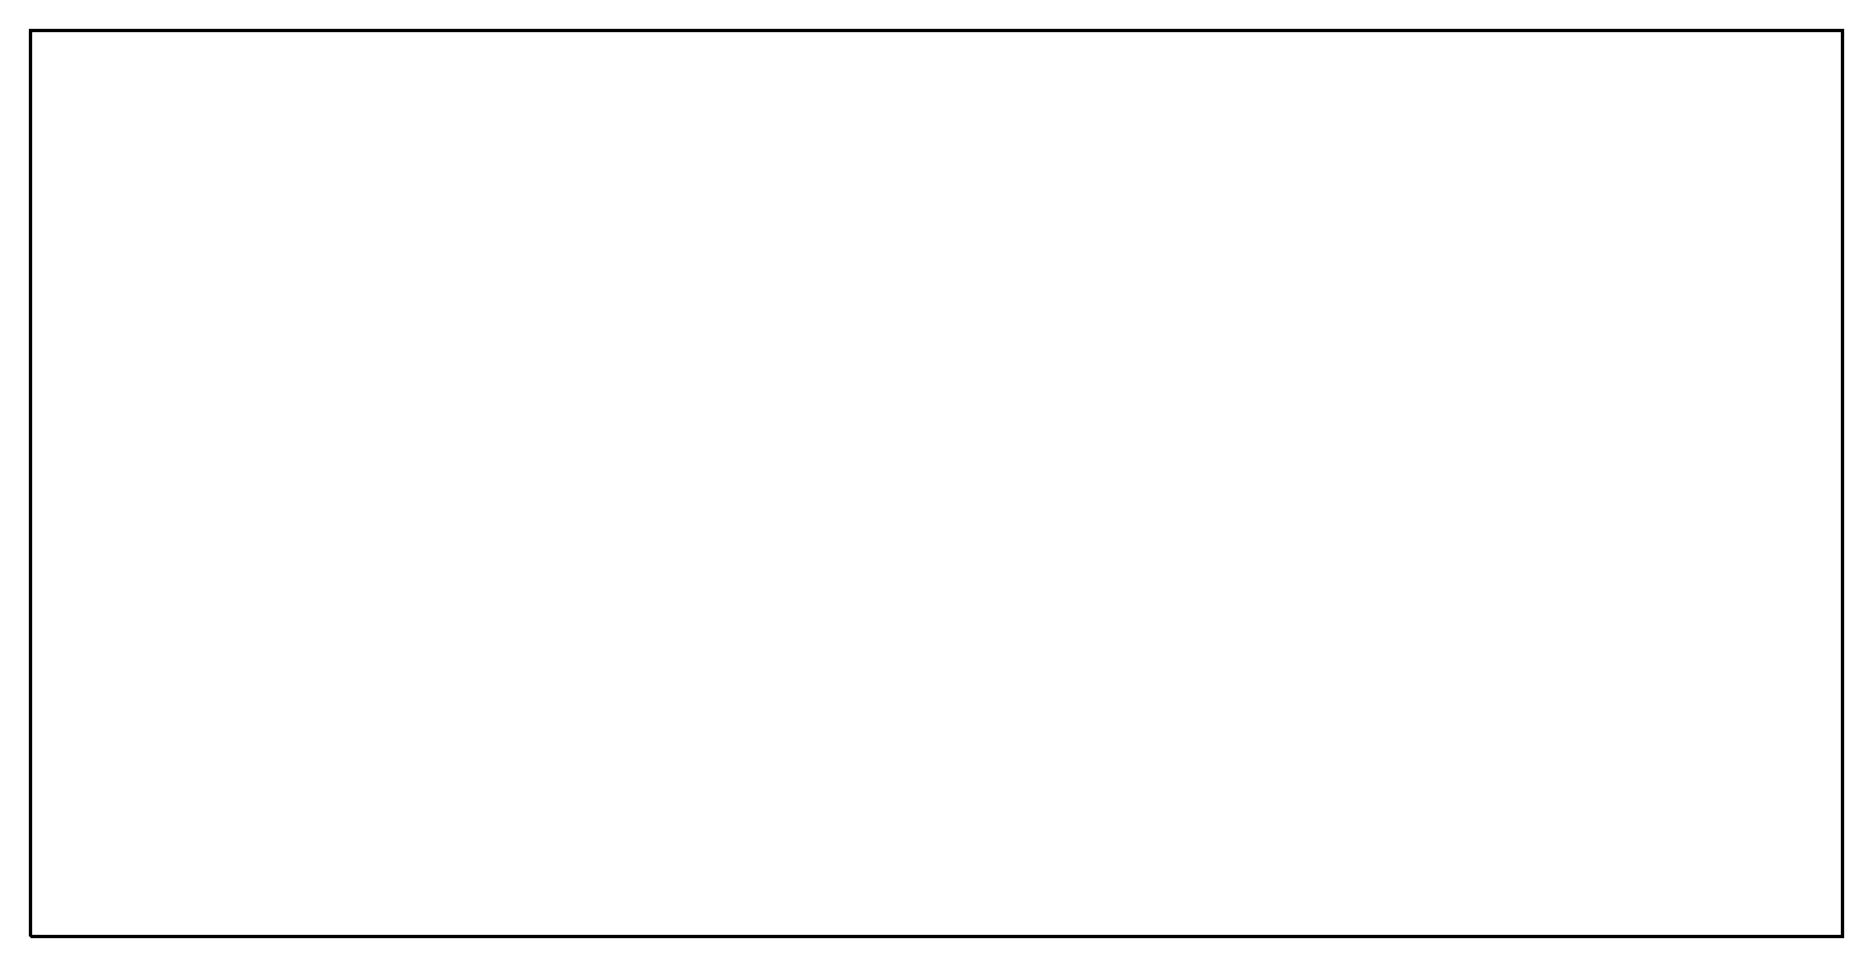

In [309]:
scale_ind = -1
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) # this opens a new plot axis
cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


# mappable = ax3.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
#                           ,cmap=cmapp, vmin=0.05, vmax=0.80)

# mappable = ax.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose()
#                           ,cmap=cmapp, vmin=0.1, vmax=1)

#cbar = plt.colorbar(mappable, ticks=np.linspace(0.1,1,6))
mapp = ax.contourf(data.lon, data.lat,dom_scale, levels=[9,12,16,22,31,42,58,79,109,200,250], cmap='Set3', transform=ccrs.PlateCarree())  # this is the actual plot
#plt.colorbar(mapp)
#ax.contour(data.lon, data.lat,power_scale, levels=np.linspace(5,30,6))

ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
#plt.title(title)
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
cbar = plt.colorbar(mapp)  # adds colorbar
cbar = plt.colorbar(maps)  # adds colorbar
plt.title('Scale: '+str(dic['scales'][scale_ind]))

In [ ]:
powery = dic['powery']
powerx = dic['powerx']
powery[powery<0.1]=0
powerx[powerx<0.1]=0

In [ ]:
ds = xr.Dataset()


ds['power_y'] = ylist
ds['power_x'] = xlist
ds['trend'] = dlist

In [24]:
all_data.Latitude.values[:,0]

array([ 3.05,  3.1 ,  3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,
        3.5 ,  3.55,  3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,
        3.95,  4.  ,  4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,
        4.4 ,  4.45,  4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,
        4.85,  4.9 ,  4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,
        5.3 ,  5.35,  5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,
        5.75,  5.8 ,  5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,
        6.2 ,  6.25,  6.3 ,  6.35,  6.4 ,  6.45,  6.5 ,  6.55,  6.6 ,
        6.65,  6.7 ,  6.75,  6.8 ,  6.85,  6.9 ,  6.95,  7.  ,  7.05,
        7.1 ,  7.15,  7.2 ,  7.25,  7.3 ,  7.35,  7.4 ,  7.45,  7.5 ,
        7.55,  7.6 ,  7.65,  7.7 ,  7.75,  7.8 ,  7.85,  7.9 ,  7.95,
        8.  ,  8.05,  8.1 ,  8.15,  8.2 ,  8.25,  8.3 ,  8.35,  8.4 ,
        8.45,  8.5 ,  8.55,  8.6 ,  8.65,  8.7 ,  8.75,  8.8 ,  8.85,
        8.9 ,  8.95,  9.  ,  9.05,  9.1 ,  9.15,  9.2 ,  9.25,  9.3 ,
        9.35,  9.4 ,

In [310]:
ds.to_netcdf('/home/ck/DIR/cornkle/data/GLOBAL_LSTtrend/LSTtrend_scales_2021_dsett10.nc')  #_cutoff0.1

NameError: name 'ds' is not defined

In [21]:
import ipdb

In [68]:
all_data = xr.open_dataset('/media/ck/Elements/global/annual_trend_data/lst_monthly_trends.nc')
all_data = all_data.where((all_data.Longitude>box[0])&(all_data.Longitude<box[1])&(all_data.Latitude>box[2])&(all_data.Latitude<box[3]), drop=True)
months = all_data['LST_trend']
# lats = all_data.Latitude[:,0]
# lons = all_data.Longitude[:,0]
                           
ylist = []
xlist = []
dlist = []
cnt=0
for ts in months:   
    print(cnt)
    mask = np.isfinite(ts.values)
    ts.values[np.isnan(ts.values)]=0.01
    dic = util.waveletT1D(ts.values, dataset='LSTATREND5K_GLOBAL', mask=mask, sign='positive')
    #del ts
    
                           
    powery = dic['powery']
    powerx = dic['powerx']
    powery[powery<0.1]=0
    powerx[powerx<0.1]=0
    #ipdb.set_trace()   

    #ipdb.set_trace()
    ylist = (xr.DataArray(powery, coords={'scales' : dic['scales'], 'lon': all_data.Longitude[:,0], 'lat': all_data.Latitude[:,0]},
                                dims=['scales', 'lon', 'lat']))  # [np.newaxis, :])
    xlist = (xr.DataArray(powerx, coords={'scales' : dic['scales'], 'lon': all_data.Longitude[:,0], 'lat': all_data.Latitude[:,0]},
                               dims=['scales', 'lon', 'lat']))

    dlist = (xr.DataArray(ts.values, coords={ 'lon': all_data.Longitude[:,0],'lat': all_data.Latitude[:,0]},
                               dims=[ 'lon', 'lat']))
    cnt = cnt+1
    del dic
    ds = xr.Dataset()
#     ds['power_y'] = xr.concat(ylist, 'time')
#     ds['power_x'] = xr.concat(xlist, 'time')
#     ds['trend'] = xr.concat(dlist,'time')   
    #ipdb.set_trace()
    ds['power_y'] = ylist
    ds['power_x'] = xlist
    ds['trend'] = dlist
    comp = dict(zlib=True, complevel=5)
    enc = {var: comp for var in ds.data_vars}

    ds.to_netcdf(path='/media/ck/Elements/global/annual_trend_data/xy_wavelets/LSTtrend_Globalscales_perMonth_POSITIVE_'+str(cnt).zfill(2)+'.nc', mode='w', encoding=enc, format='NETCDF4')
    del ds

0
1
2
3
4
5
6
7
8
9
10
11


In [139]:
#box = [-18,20,3,12]

box = [-66,-60,-13.5,-8.5]

In [156]:
test = xr.open_dataset('/media/ck/LStorage/global_water/other/LST_trend_global/LSTtrend_scales_perMonth_POSITIVE_09.nc')

In [146]:
test = test.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))

In [147]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [148]:
print(test['trend'].shape)
print(test.lat.shape)

(121, 101)
(101,)


/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


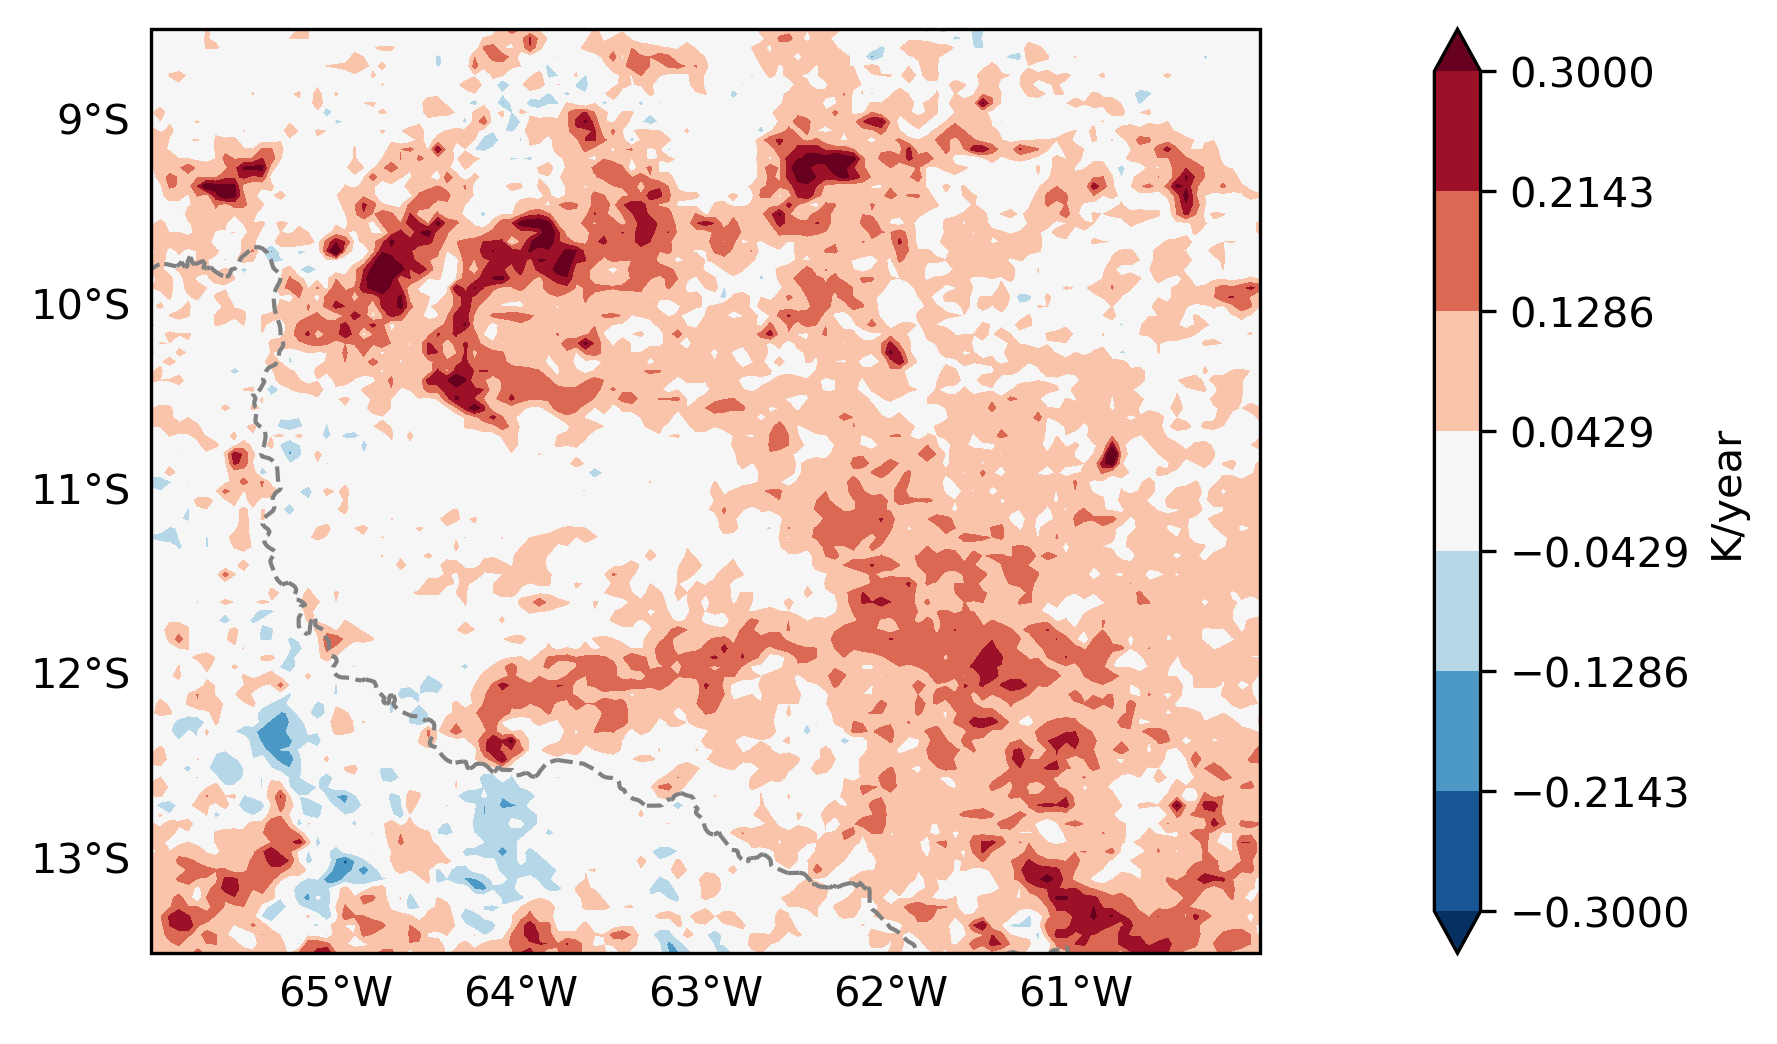

In [154]:
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())

draw_map(ax,test['trend'].values.T, test.lat, test.lon, levels=np.linspace(-0.3,0.3,8), clabel='K/year')
# mapp = ax.contour(test['power_y'].values.T, test.lat, test.lon, levels=np.linspace(0.1,60,16))
# mapp = ax.contour(test['power_y'].values.T, test.lat, test.lon, levels=np.linspace(0.1,60,16), cmap='jet')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


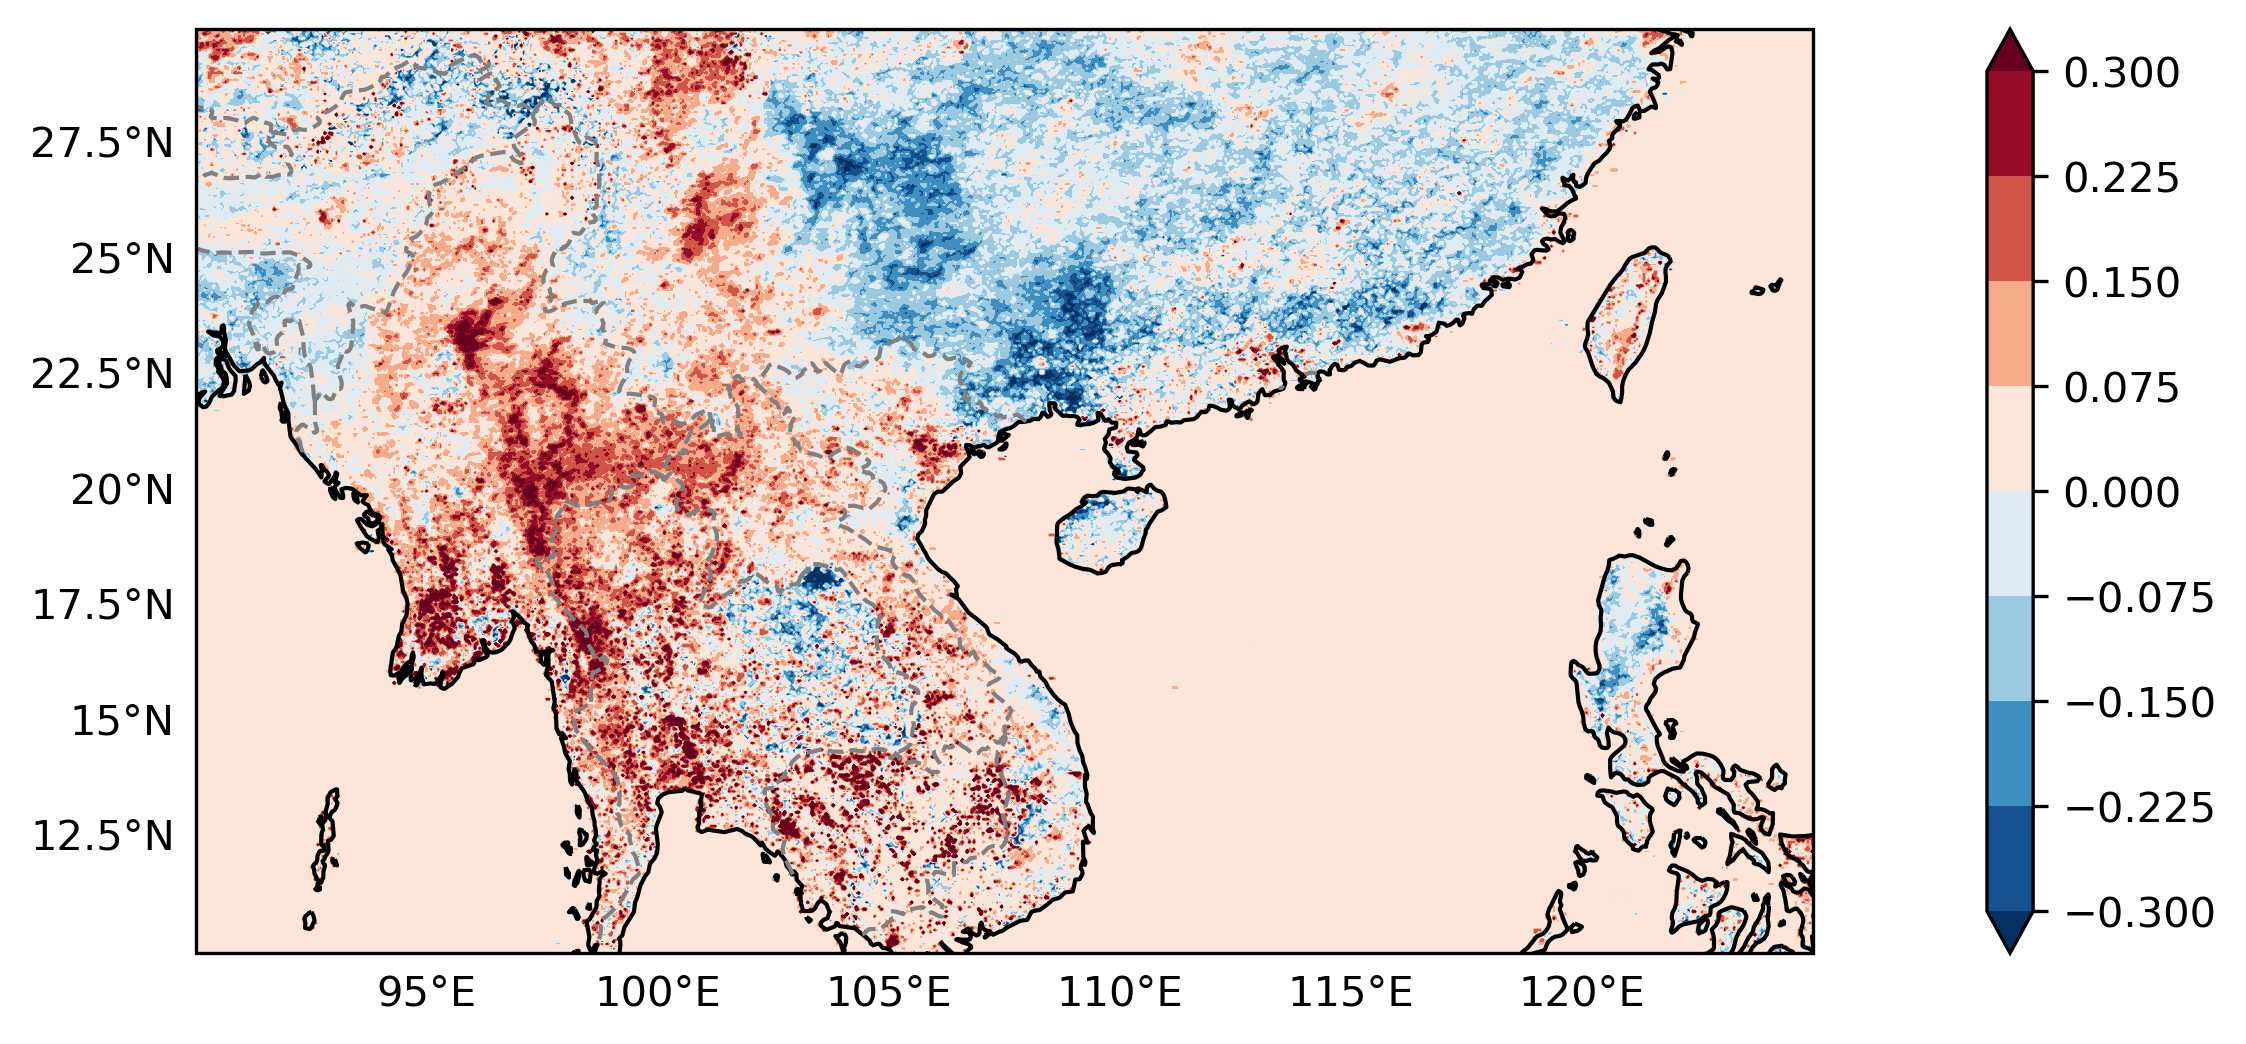

In [134]:
box = [90,125,10,30]

test = xr.open_dataset('/media/ck/LStorage/global_water/other/LST_trend_global/LSTtrend_scales_perMonth_POSITIVE_05.nc')
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
test2 = test.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
draw_map(ax,test2['trend'].values.T, test2.lat, test2.lon, levels=np.linspace(-0.3,0.3,9))

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


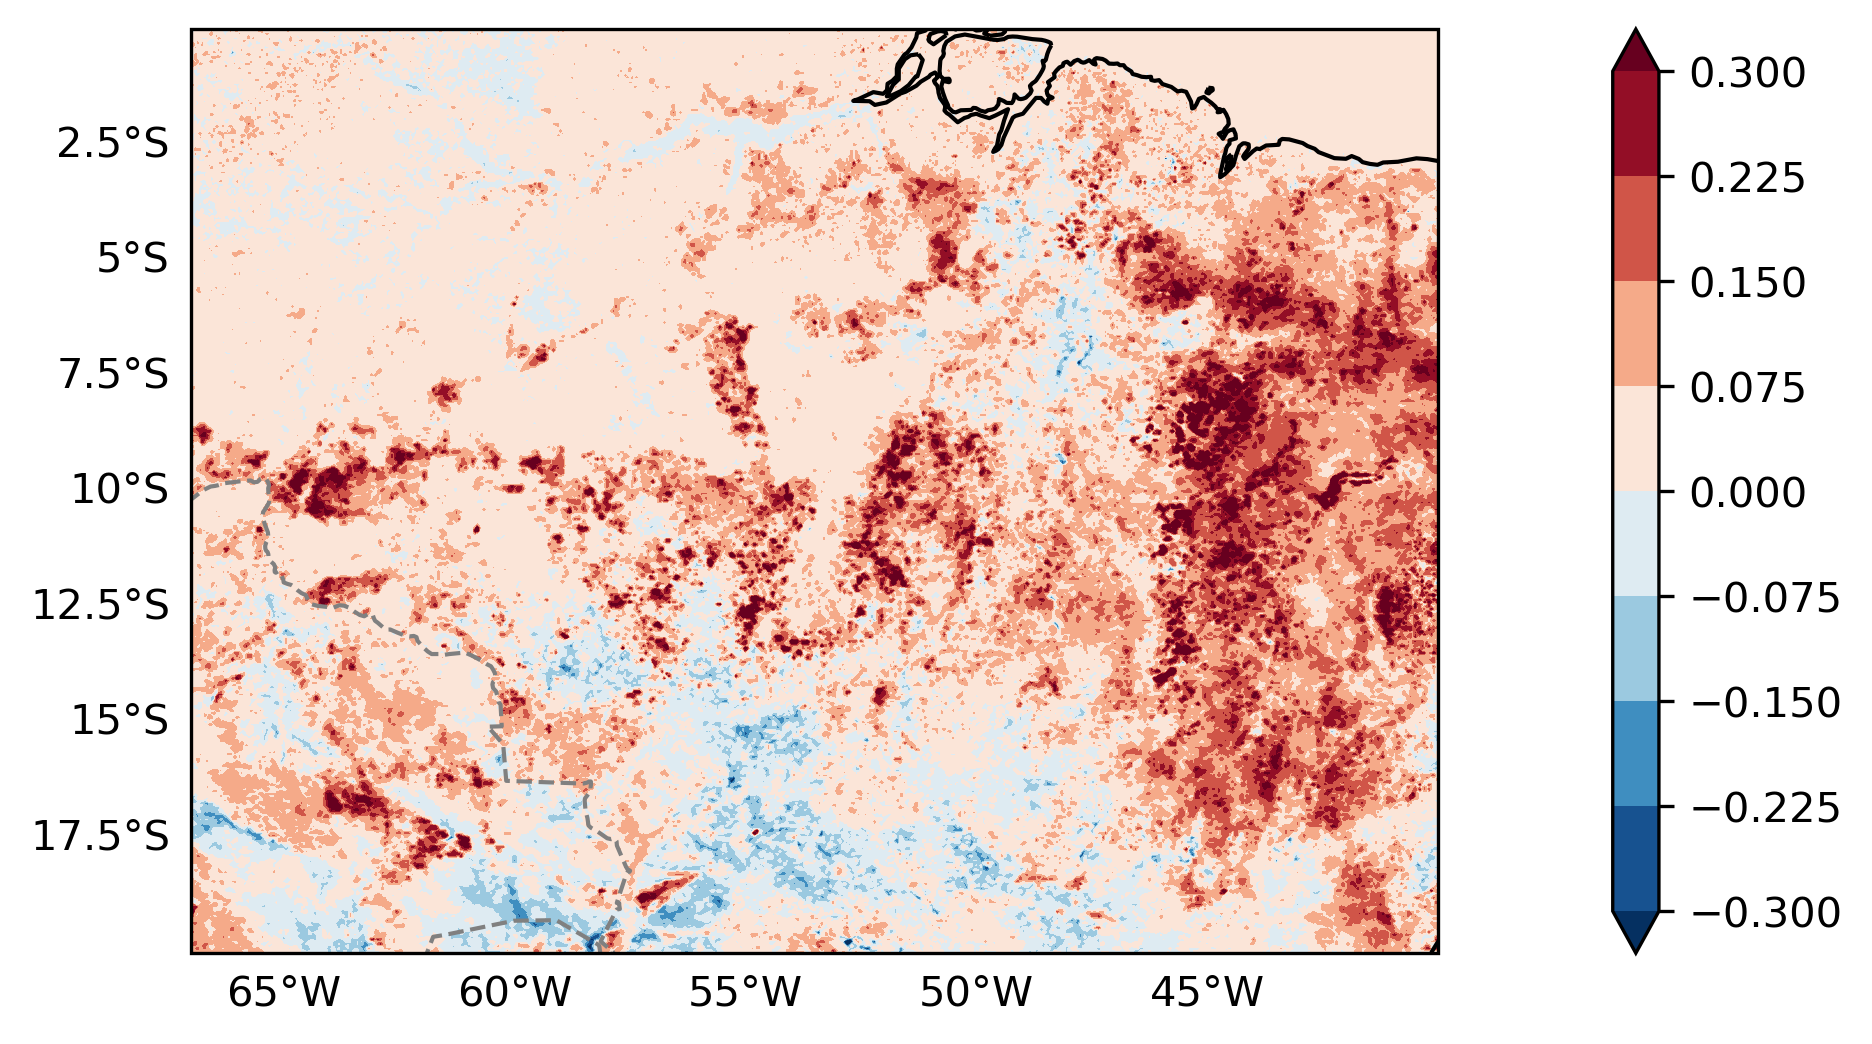

In [117]:
box = [-67,-40,-20,0]
test2 = test.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())

draw_map(ax,test2['trend'].values.T, test2.lat, test2.lon, levels=np.linspace(-0.3,0.3,9))

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


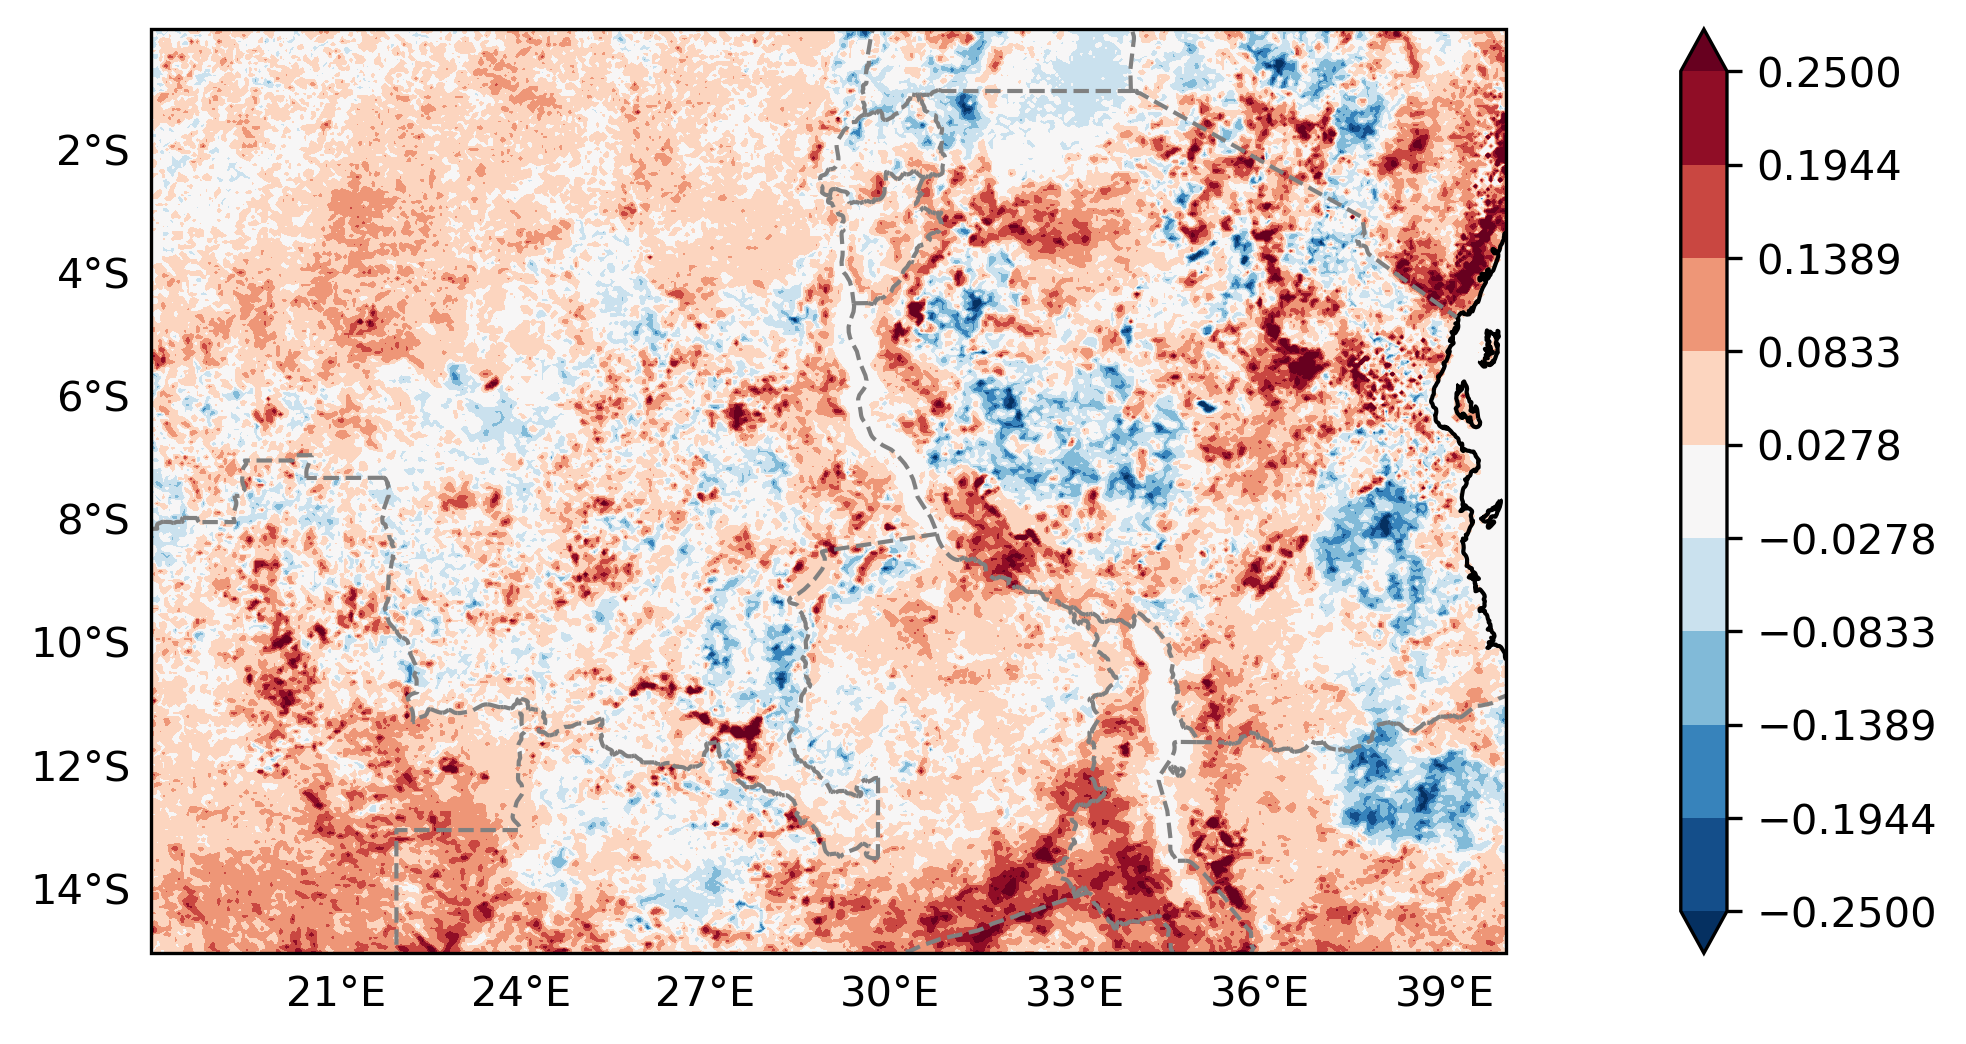

In [125]:
test = xr.open_dataset('/media/ck/LStorage/global_water/other/LST_trend_global/LSTtrend_scales_perMonth_POSITIVE_07.nc')

box = [18,40,-15,0]
test2 = test.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())

draw_map(ax,test2['trend'].values.T, test2.lat, test2.lon, levels=np.linspace(-0.25,0.25,10))

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


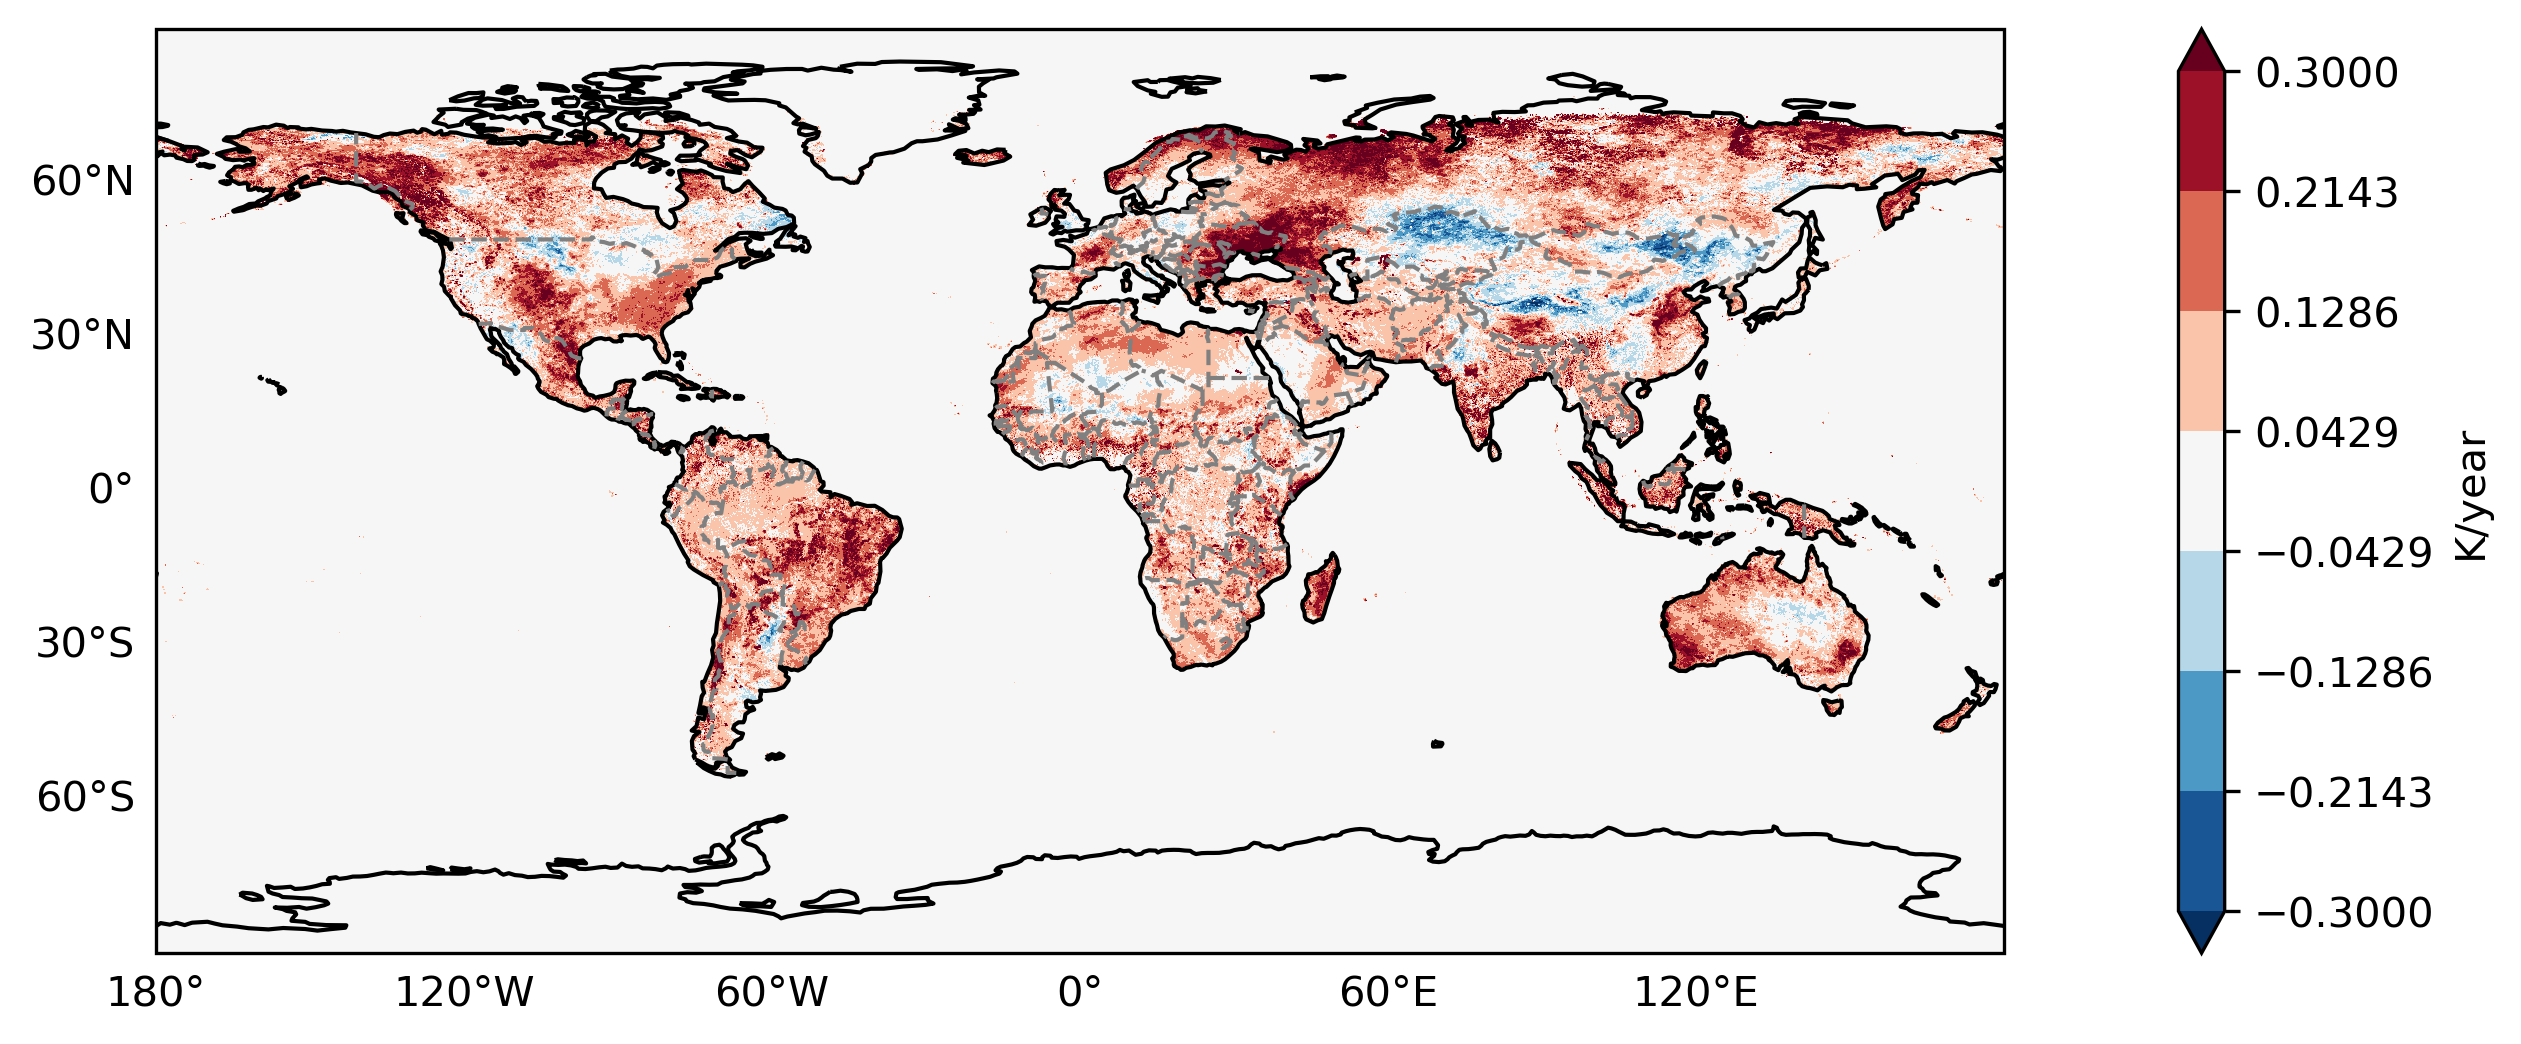

In [158]:
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())

draw_map(ax,test['trend'].values.T, test.lat, test.lon, levels=np.linspace(-0.3,0.3,8), clabel='K/year')

5
[16 16 17 17 17 18 18 18 19 19 19 20 20 20 20 21 21 21 22 22 22 23 23 23
 24 24]


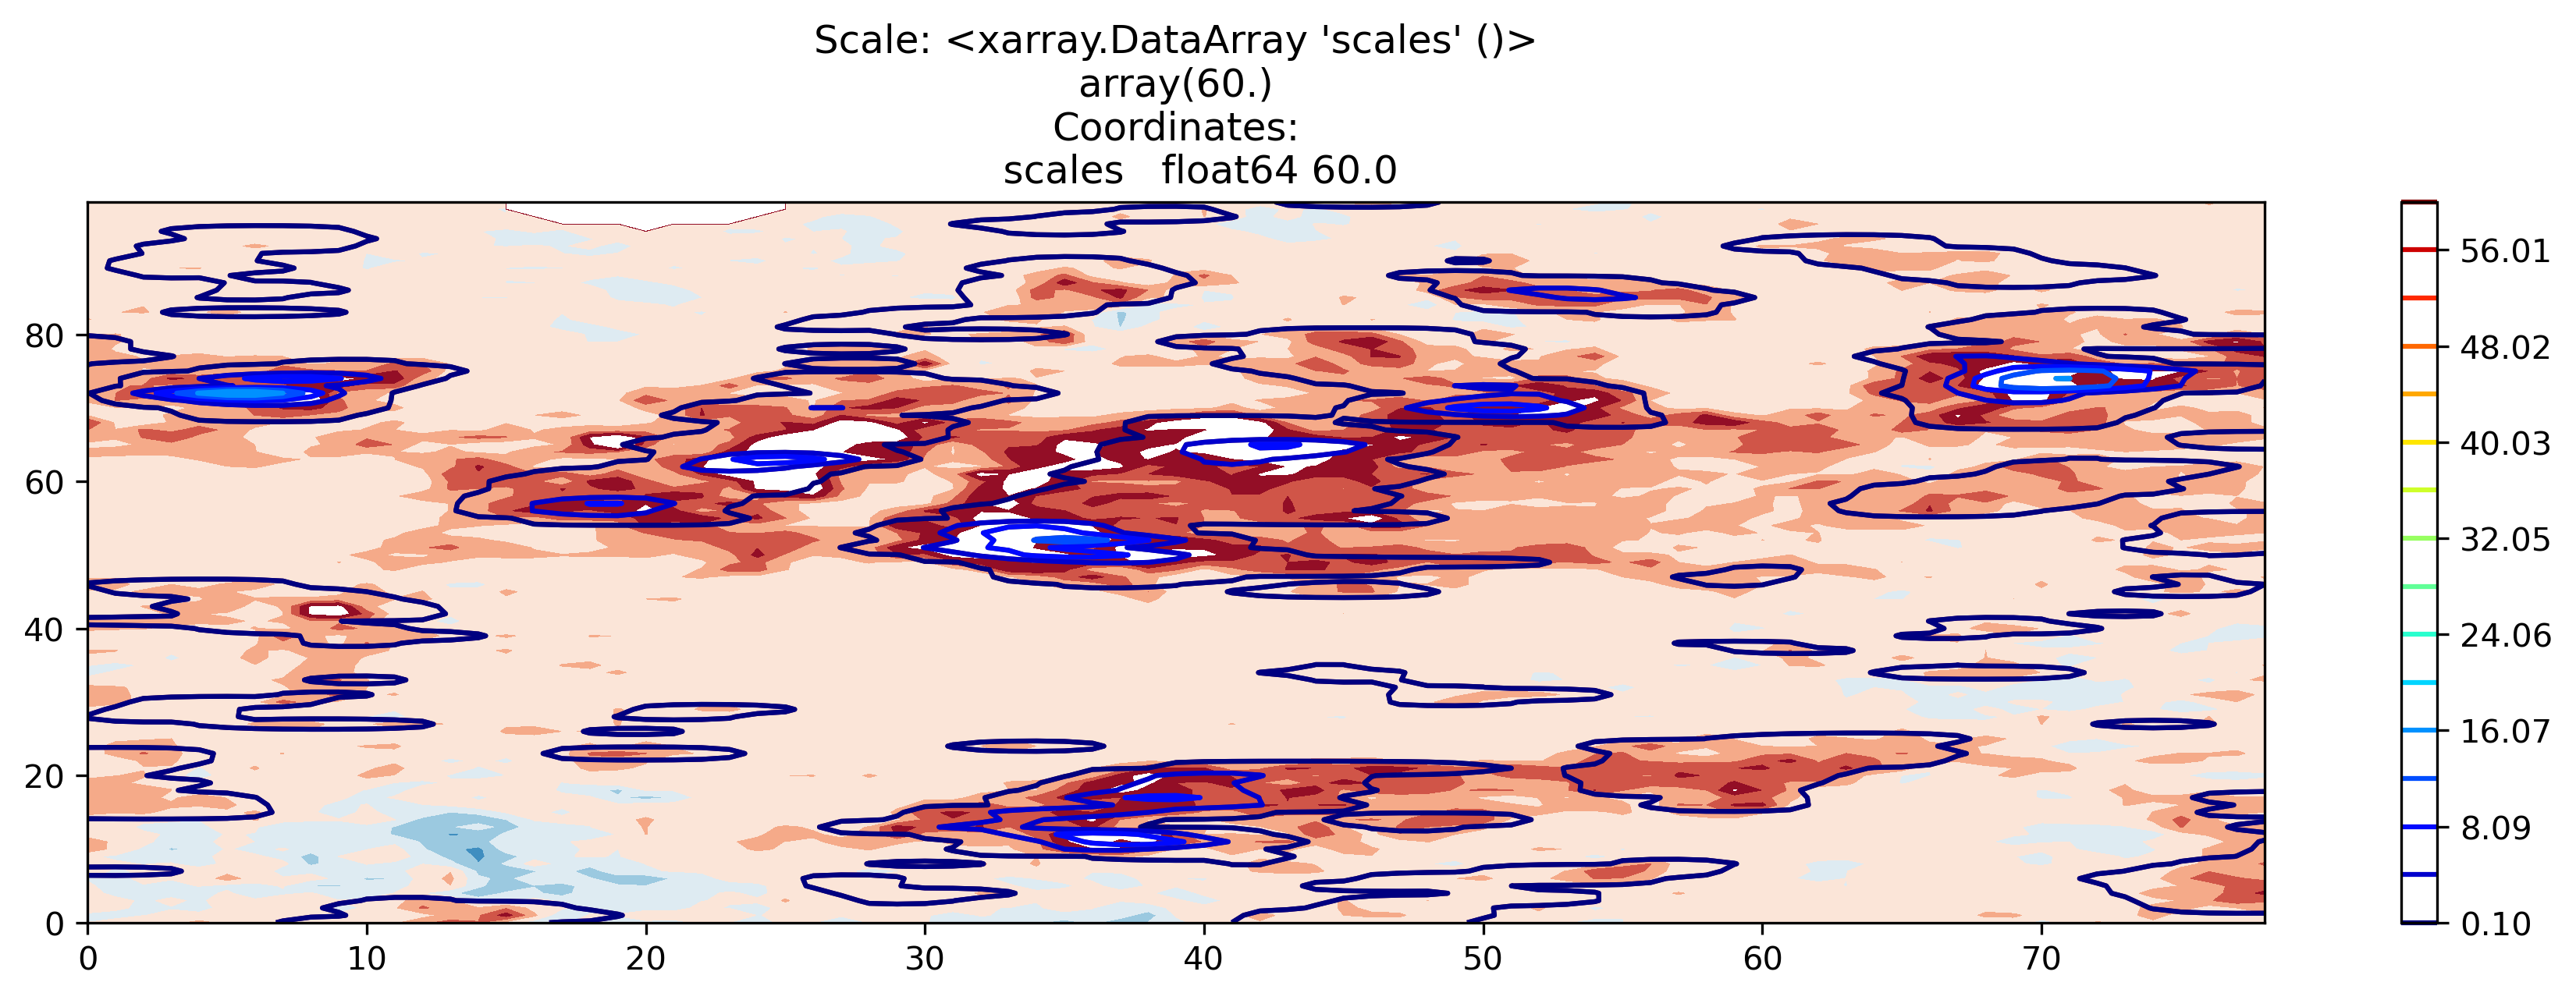

In [6]:
scale_ind = 5
data = test.isel(scales=scale_ind)
iscale = (np.floor(test['scales'][scale_ind].values / 2. / 5.55)).astype(int)
print(iscale)
#ipdb.set_trace()
ycircf, xcircf = ua.draw_cut_circle(100, 20, iscale, data['trend'].values)
print(ycircf)
data['trend'].values[ycircf,xcircf] = 50
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111)
mapp = ax.contourf(data['trend'].values.T,levels=np.linspace(-0.3,0.3,9), cmap='RdBu_r')
mapp = ax.contour(data['power_y'].values.T, levels=np.linspace(0.1,60,16))
mapp = ax.contour(data['power_y'].values.T, levels=np.linspace(0.1,60,16), cmap='jet')
#mapp = ax.contour(dic['powery'][4,:,:], levels=np.linspace(7,60,6), cmap='Greens')
plt.title('Scale: '+str(test['scales'][scale_ind]))


plt.colorbar(mapp)